# Chapter 11 메타 학습

## 11.1 메타 러닝과 퓨샷 러닝
- Meta-learning: 메타 데이터라고 불리는 방대한 데이터를 이용해 학습하는 방법을 학습하여 적은 데이터로도 새로운 문제를 빠르게 풀 수 있게 하는 방법론
- Few-shot learning: 적은 양의 데이터를 가진 여러 가지 업무 Task 세트가 존재할 때 그 업무 세트를 가지고 학습하는 방법을 학습하여 새로운 업무에 대해서 적은 양의 데이터라도 빠르게 학습할 수 있는 메타 학습 방법 중 하나


- 메타 훈련 데이터: 사전 지식으로 생각할 수 있는 이미 가지고 있는 데이터
- 메타 테스트 데이터: 우리가 한 번도 보지 못한 데이터
=> 메타 훈련 데이터에 있는 정보는 메타 테스트 데이터에는 존재하지 않음. 즉, 데이터가 갖춰지는 우리는 메타 훈련 데이터를 이용하여 퓨샷 러닝을 진행하고 이로부터 얻어진 모델을 가지고 메타 테스트에서 성능을 확인하는 것

메타 데이터
- 서포트 세트 Support set: 학습에 직접 사용
- 쿼리 세트 Query set: 모델 업데이트를 위해 사용

학습 방식
- 최적화 기반 메타 학습 Optimization-based meta-Learning
  - 메타 훈련 데이터를 통해 어떤 식으로 모델을 최적화해야 일반적인 모델 파라미터를 얻을 수 있을지 학습하는 방법
  - 대표적으로 Model-Agnostic Meta-Learning, MAML이 있음

## 11.2 MAML - 회귀 문제
- 임의의 사인 함수 위에 몇 개의 점만 주어졌을 때 사인 그래프에 대한 예측을 한다.

In [2]:
# 라이브러리 불러오기

import torch
from torch import nn, optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from matplotlib import pyplot as plt

In [3]:
# GPU 연산 확인하기

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [4]:
# 데이터 생성 클래스 정의하기
# 배치 데이터 형태로 만들기 위해 텐서 데이터셋을 정의함. 입력값은 텐서이므로 별도의 텐서 변환은 진행X

class TensorData(Dataset):
  def __init__(self,x_data,y_data):
    self.x_data = x_data
    self.y_data = y_data
    self.len = self.y_data.shape[0]
  def __getitem__(self,index):
    return self.x_data[index], self.y_data[index]
  def __len__(self):
    return self.len

In [13]:
# 데이터는 사인 함수 y = a *sin(x+b)

class SinusoidalFunction: # x정의역의 범위, 각 함수의 데이터 포인트 개수, 함수 개수에 해당하는 업무 수
  def __init__(self,x_range=5,k=5,num_tasks=4):
    self.x_range = x_range # [-x_range, x_range]
    self.pi = torch.acos(torch.zeros(1)).item() * 2
    self.k = k
    self.num_tasks = num_tasks

  # 메타 학습 데이터를 만드는 함수
  def meta_train_data(self):
    # 구간 [-5,5] 내에서 데이터를 2*self.k만큼 무작위로 업무 수만큼 뽑음.
    # 이유는 서포트 세트에 k개, 쿼리 세트에 k개를 할당하기 위함.
    # 만약 각 함수마다 5개씩 데이터를 갖는 100개의 업무가 있다면 x_points의 크기는 (100,10)이 되며
    # 10개의 포인트 중 5개는 서포트 세트의 원소이고, 나머지 5개는 쿼리 세트의 원소가 됨
    x_points = 2*self.x_range*(torch.rand((self.num_tasks,2*self.k))-0.5) # S and Q
    # 각 함수값 저장을 위해 빈 텐서를 만들고 각 업무마다 10개의 데이터를 받아 임의의 함수값 구함
    y_points = torch.tensor([],dtype=torch.float)
    for x in x_points:
      a = 4 * (torch.rand(1) + 0.1)
      b = self.pi * torch.rand(1) # [0, pi]
      y = a * torch.sin(x.view(1,-1) + b)
      y_points = torch.cat((y_points, y), 0)
    taskset = TensorData(x_points, y_points)
    trainloader = torch.utils.data.DataLoader(taskset, batch_size=1)
    return trainloader

  # 메타 테스트 데이터도 동일하게 각 포인트 데이터 생성
  def meta_eval_data(self,k):
    x_points = 2*self.x_range*(torch.rand(2*k)-0.5)
    a = 4 * (torch.rand(1) + 0.1)
    b = self.pi * torch.rand(1) # [0, pi]
    y_points = a * torch.sin(x_points + b)
    sup_x = x_points[:k]
    sup_y = y_points[:k]
    que_x = x_points[k:]
    que_y = y_points[k:]
    # 검증 확인을 위해 점 200개에 대한 실제 그래프 데이터 생성
    x = torch.linspace(-self.x_range,self.x_range,200)
    y = a * torch.sin(x+b)
    return sup_x, sup_y, que_x, que_y, x, y

In [14]:
# 데이터 생성하기
# 2000개의 사인 함수마다 5개의 점만 알고 있다고 가정하고 데이터 생성

k = 5
num_tasks = 2000
sine = SinusoidalFunction(k=k, num_tasks=num_tasks)
trainloader = sine.meta_train_data()

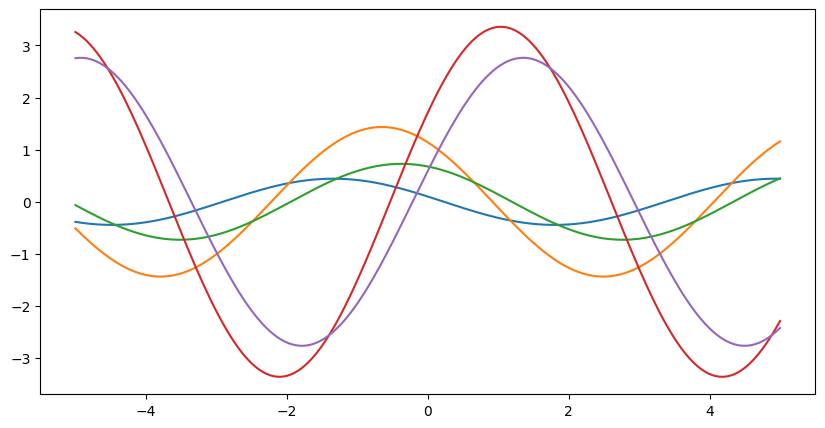

In [15]:
# 데이터 함수 확인하기
# 임의의 함수 5개를 출력

plt.figure(figsize=(10,5))
for i in range(5):
  _,_,_,_,x,y = sine.meta_eval_data(5)
  plt.plot(x,y)
plt.show()
plt.close()

In [16]:
# 모델 구축하기: 입력층, 2개의 은닉층, 출력층으로 구성된 MLP로 정의

class Regressor(nn.Module):
  def __init__(self):
    super().__init__()
    self.fc1 = nn.Linear(1,40)
    self.fc2 = nn.Linear(40,40)
    self.fc3 = nn.Linear(40,1)

  def forward(self,x):
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    x = self.fc3(x)
    return x

  def parameterised(self,x,weights):
    x = F.relu(F.linear(x,weights[0],weights[1]))
    x = F.relu(F.linear(x,weights[2],weights[3]))
    x = F.linear(x,weights[4],weights[5])
    return x

In [19]:
# 메타 학습 모델 구축하기

# 각 업무마다 서포트 데이터로 내부적으로 모델을 업데이트하여 쿼리 데이터 예측
# 사용되는 학습률 beta를 정하고 각 업무의 쿼리 데이터로부터 얻어진 손실 함수값의 합으로
# 정의된 손실 함수값을 기준으로 모델을 업데이트하여 실제 일반적인 파라미터를 구하기 되는데, 이때 사용되는 학습률 alpha를 불러옴
class MAML:
  def __init__(self, trainloader, k, alpha = 1e-2, beta = 1e-3):
    self.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    self.k = k # 각 업무의 데이터 개수 정의
    self.model = Regressor().to(device)
    self.weights = list(self.model.parameters()) # 모델 파라미터 저장
    self.trainloader = trainloader
    self.beta = beta
    self.criterion = nn.MSELoss() # 함수 예측 회귀 문제로 MSE 손실 함수 사용
    # 메타 학습을 위해 Adam 사용
    # 메타 학습의 최종 업데이트에는 self.model.parameters()를 이용하고, 각 업무별 업데이트는 self.weights 이용
    self.optimizer = optim.Adam(self.model.parameters(), lr=alpha)


  # 함수를 통해 각 업무 수행
  def inner_loop(self, data):
    # self.weights을 이용한 모델을 사용하여 업무별 업데이트를 한다
    temp_weights = [w.clone() for w in self.weights]
    inputs, values = data[0].to(device), data[1].to(device)
    # 우리가 구성한 data는 서포트 세트와 쿼리 세트가 모두 포함된 형태이므로 각각 나눠줌
    support_x = inputs[:,:self.k].T
    support_y = values[:,:self.k].T
    query_x = inputs[:,self.k:].T
    query_y = values[:,self.k:].T

    # 정해진 학습 횟수만큼 서포트 데이터를 이용하여 temp_weights 업데이트
    outputs = self.model.parameterised(support_x, temp_weights)
    loss = self.criterion(outputs, support_y)
    grad = torch.autograd.grad(loss, temp_weights)
    tmp = [w - self.beta * g for w, g in zip(temp_weights, grad)]
    # 업데이트된 모델을 바탕으로 쿼리 데이터를 예측하고 손실 함수 구함
    outputs = self.model.parameterised(query_x, tmp)
    inner_loss = self.criterion(outputs, query_y)
    return inner_loss


  # 메타 학습 함수 정의
  def meta_train(self,num_epochs):
    n = len(self.trainloader)
    loss_list = []
    for epoch in range(num_epochs):
      self.optimizer.zero_grad()
      outer_loss = 0
      # 각 업무를 불러옴
      for data in self.trainloader:
        outer_loss += self.inner_loop(data) # 각 업무마다 손실 함수 계산하여 모두 합함

      avg_loss = outer_loss/n
      avg_loss.backward()
      self.optimizer.step()
      ll = avg_loss.item()
      loss_list.append(ll)
      if epoch % 10 == 0:
        print(epoch, ll)
    return loss_list

In [20]:
# 메타 학습 수행하기
# 손실 함수값의 변화에 대한 리스트

maml = MAML(trainloader, k=k)
loss = maml.meta_train(201)

0 3.3523788452148438
10 2.9150052070617676
20 2.7237913608551025
30 2.5825791358947754
40 2.435480833053589
50 2.337580680847168
60 2.2935523986816406
70 2.2714407444000244
80 2.253281831741333
90 2.241316556930542
100 2.22655987739563
110 2.2161738872528076
120 2.2041478157043457
130 2.190185546875
140 2.177762746810913
150 2.1654422283172607
160 2.1585092544555664
170 2.1394059658050537
180 2.1267757415771484
190 2.111097812652588
200 2.097545623779297


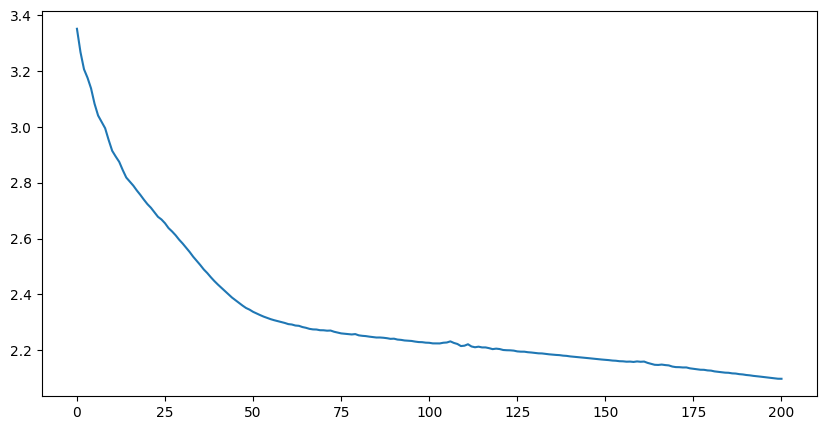

In [21]:
# 메타 학습 손실 함수 그래프 그리기

plt.figure(figsize=(10,5))
plt.plot(loss)
plt.show()

In [22]:
# 메타 학습 검증 함수 정의하기

def inference(sup_x,sup_y,x,y,model): # 메타 테스트 데이터와 모델을 받음
  with torch.no_grad():
    pred = model(x.view(-1,1).to(device)) # 정의된 전구간에 대해 예측 시행
    plt.figure(figsize=(10,5))
    plt.plot(x.cpu().detach(),pred.cpu().detach(),'-b')
    plt.plot(sup_x.cpu().detach(),sup_y.cpu().detach(),'.g')
    plt.plot(x,y,'--r')
    plt.legend(['prediction','actual points','actual graph'])
    plt.show()
    plt.close()

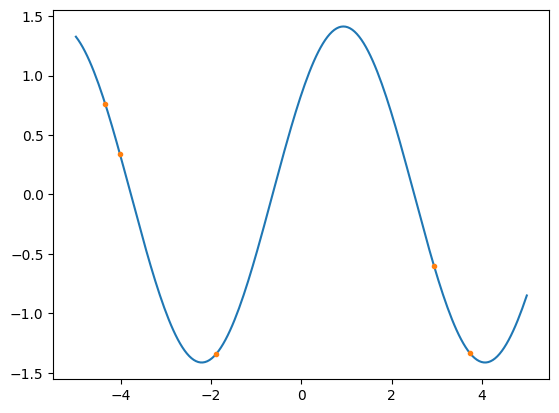

In [23]:
# 메타 테스트 데이터 생성하기

sup_x,sup_y,_,_,x,y = sine.meta_eval_data(5)
plt.plot(x,y)
plt.plot(sup_x,sup_y,'.')
plt.show()

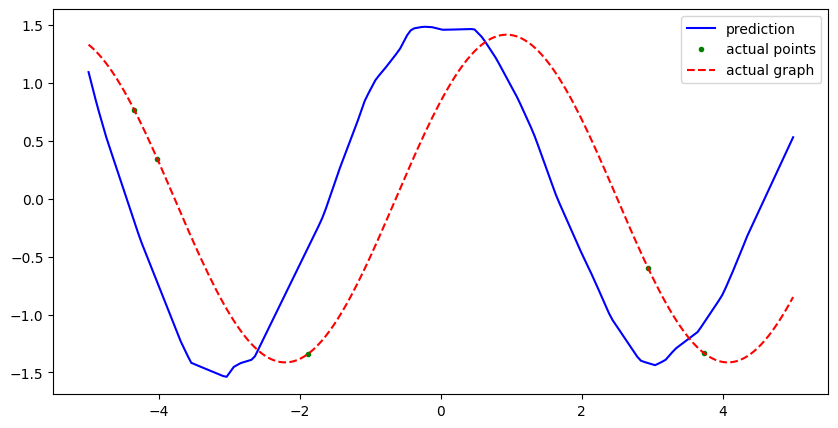

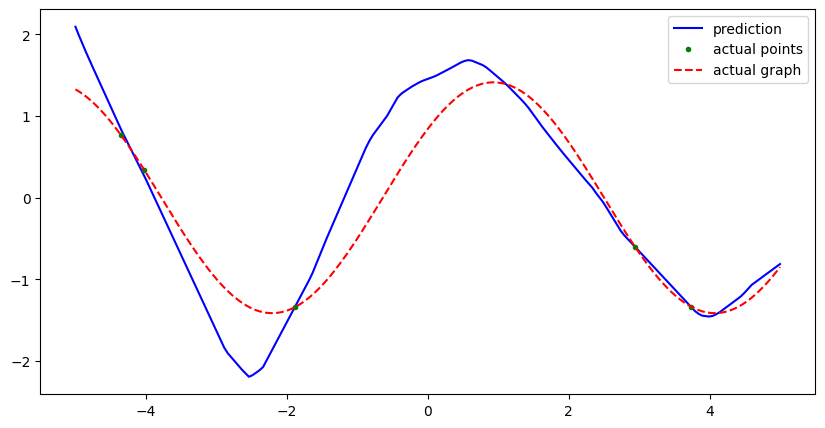

In [24]:
# 메타 학습 검증하기

pre = maml.model
criterion = nn.MSELoss()
optimizer = optim.Adam(pre.parameters(),lr=1e-3)
num_epochs = 501
# 메타 테스트 데이터에서 5개의 서포트 데이터만을 이용해 모델 학습 후
for i in range(num_epochs):
  optimizer.zero_grad()
  outputs = pre(sup_x.view(-1,1).to(device))
  loss = criterion(outputs,sup_y.view(-1,1).to(device))
  loss.backward()
  optimizer.step()
  # 전체 범위에 대해 처음과 마지막 결과에 대해 출력
  if i == 0:
    inference(sup_x,sup_y,x,y,pre)
  elif i == num_epochs-1:
    inference(sup_x,sup_y,x,y,pre)

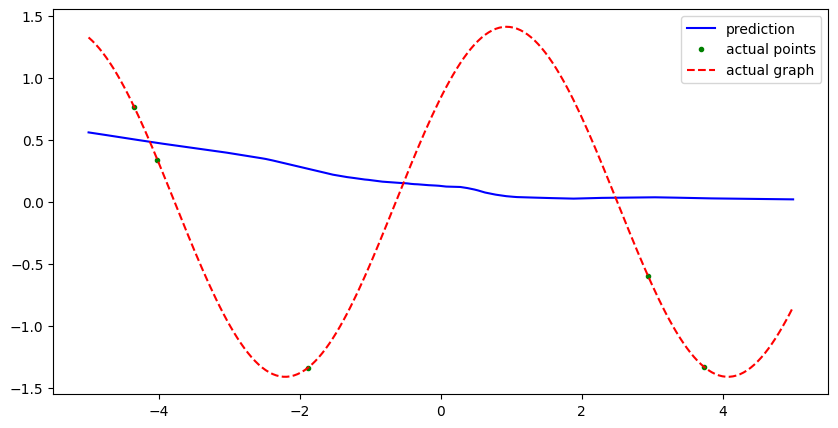

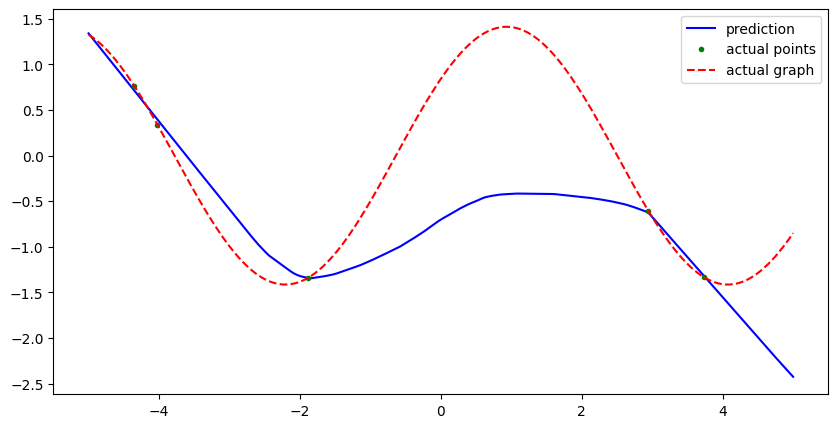

In [25]:
# 기본적인 지도 학습 진행하기

net = Regressor().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(net.parameters(),lr=1e-3)

for i in range(num_epochs):
  optimizer.zero_grad()
  outputs = net(sup_x.view(-1,1).to(device))
  loss = criterion(outputs,sup_y.view(-1,1).to(device))
  loss.backward()
  optimizer.step()
  if i == 0:
    inference(sup_x,sup_y,x,y,net)
  elif i == num_epochs-1:
    inference(sup_x,sup_y,x,y,net)

## 11.3 MAML - 분류 문제
- CIFAR 100 이미지를 이용하여 퓨샷 러닝 구현

In [4]:
# 라이브러리 불러오기

import torch
from torch import nn, optim
import torch.nn.functional as F
import torchvision
import torchvision.transforms as tr
from torch.utils.data import DataLoader, Dataset
from matplotlib import pyplot as plt
import numpy as np
import copy

In [5]:
# GPU 연산 확인하기

devcie = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [6]:
# 데이터 전처리 클래스 정의하기: 전처리 작업의 확장 및 관리를 용이하게 하기 위해 클래스 별도로 정의

class MyTransform:
  def __call__(self,sample,mode):
    inputs1, inputs2, labels = sample # 서포틍 ㅣ미지, 쿼리 이미지, 해당 라벨
    if mode == "train": # 만약 데이터가 메타 훈련 세트에 있다면 서포트 이미지에 대해서 전처리 시행
      transf = tr.RandomHorizontalFlip()
      output1 = transf(inputs1)
    else: # 그렇지 않으면 전처리 시행하지 않음
      output1 = inputs1
    return output1, inputs2, labels

In [7]:
# 텐서 데이터 클래스 정의하기 (넘파이->텐서)

class TensorData(Dataset):
  # 서포트 세트와 쿼리 세트는 크기를 (배치 크기, 채널 수, 이미지 너비, 이미지 높이)로 변환하기 위해 permute
  def __init__(self,support_set,query_set,labels,mode="train"):
    self.support_set = torch.FloatTensor(support_set).permute(0,3,1,2)
    self.query_set = torch.FloatTensor(query_set).permute(0,3,1,2)
    self.labels = torch.LongTensor(labels)
    self.len = self.labels.shape[0]
    self.transform = MyTransform() # 전처리
    self.mode = mode
  def __getitem__(self, index):
    sample = self.support_set[index], self.query_set[index], self.labels[index]
    sample = self.transform(sample, self.mode)
    return sample
  def __len__(self):
    return self.len

In [16]:
# CIFAR100 데이터 클래스 정의하기

class CIFAR100DataSet:
  # 메타 학습에 대한 문제 정의. 기본적으로 클래스가 5개이고 각 클래스마다 이미지가 5장이 있는 5way-5shot 문제를 다룬다
  def __init__(self, Nway=5, fewshot=5):
    self.cifar = torchvision.datasets.CIFAR100(root='./data',train=True,download=True)
    self.Nway = Nway
    self.fewshot = fewshot


  # 업무 하나를 생성하는 함수 정의: 클래스 정보를 받아서 각 클래스마다 미리 설정한 이미지 개수를 생성하는 함수
  def task_generator(self, cls, mode="train"):
    labels = np.array(self.cifar.targets) # 전체 라벨 정보 정의
    data = self.cifar.data / 255 # 전체 이미지 데이터 받음
    # 해당 업무 내의 서포트 세트, 쿼리 세트와 그에 대응하는 라벨을 저장하기 위한 리스트를 만듦
    support_set = []
    query_set = []
    targets = []

    # 클래스를 하나씩 할당하여 세트를 구성. 이미지는 서포트 세트와 쿼리 세트마다 self.fewshot개만큼 들어가므로 2* self.fewshot개만큼 이미지 인덱스 무작위로 뽑음
    for i,c in enumerate(cls):
      idx = np.where(labels == c)[0]
      rand = np.random.choice(len(idx), 2*self.fewshot, replace=False)
      # 뽑은 인덱스 바탕으로 세트 각각 self.fewshot개의 이미지 할당
      for shot in range(2*self.fewshot):
        img = data[idx[rand[shot]]]
        if shot < self.fewshot:
          support_set.append(img)
          targets.append(i)
        else:
          query_set.append(img)
    # 리스트로 구성된 세트와 라벨을 넘파이 배열로 바꾸고 텐서 데이터로 변환
    support_set = np.stack(support_set)
    query_set = np.stack(query_set)
    targets = np.array(targets)
    taskset = TensorData(support_set,query_set,targets,mode=mode)
    dataloader = torch.utils.data.DataLoader(taskset,batch_size=self.Nway*self.fewshot, shuffle=False)
    return dataloader

  # 다수의 업무를 만드는 함수 정의
  def task_set(self,num_tasks,cls,mode="train"):
    task_collection = [] # 업무 모음
    for i in range(num_tasks):
      task_collection.append(self.task_generator(cls,mode=mode))
    return task_collection

In [17]:
# CIFAR100 샘플 이미지 확인하기

cifar100 = CIFAR100DataSet(Nway=5,fewshot=5)
# 임의로 클래스 5개를 뽑아 업무 하나 생성
trainloader = cifar100.task_generator(cls=[0,10,20,50,70])
# 데이터 불러옴
data1,data2,label = next(iter(trainloader))
# 5way-5shot 문제이므로 각 세트마다 25장의 32x32 이미지가 들어 있는지 확인
print(data1.size(),data2.size(),label.size())

Files already downloaded and verified
torch.Size([25, 3, 32, 32]) torch.Size([25, 3, 32, 32]) torch.Size([25])


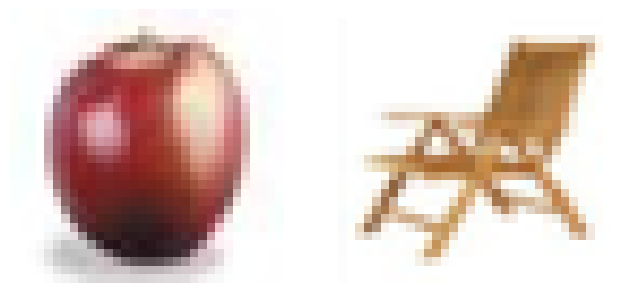

In [18]:
oneshot1 = data1[0].permute(1,2,0).numpy()
oneshot2 = data2[10].permute(1,2,0).numpy()
plt.figure(figsize=(12,4))
plt.subplot(131)
plt.imshow(oneshot1)
plt.axis("off")
plt.subplot(132)
plt.imshow(oneshot2)
plt.axis("off")
plt.show()

In [19]:
# 모델 정의하기
# MAML의 학습 시간을 줄이고 이해를 돕기 위해 간단한 합성곱 신경망을 구성

class CNN(nn.Module):
  def __init__(self,Nway):
    super(CNN,self).__init__()
    self.features = nn.Sequential(
        nn.Conv2d(3,64,3), nn.ReLU(),
        nn.MaxPool2d(2,2),
        nn.Conv2d(64,128,3,stride=1,padding=1),nn.ReLU(),
        nn.MaxPool2d(2,2),
        nn.Conv2d(128,256,3,stride=1,padding=1),nn.ReLU(),
        nn.Conv2d(256,256,3,stride=1), nn.ReLU(),
        nn.Conv2d(256,256,3,stride=1), nn.ReLU()
    )
    self.classifier = nn.Sequential(nn.Linear(256,128), nn.ReLU(), nn.Linear(128,Nway))

  def forward(self,x):
    x = self.features(x)
    x = torch.mean(x, [2,3])
    x = self.classifier(x)
    return x

  def parameterised(self,x,weights):
    x = F.relu(F.conv2d(x,weight=weights[0],bias=weights[1],stride=1))
    x = F.max_pool2d(x,kernel_size=2,stride=2)
    x = F.relu(F.conv2d(x,weight=weights[2],bias=weights[3],stride=1,padding=1))
    x = F.max_pool2d(x,kernel_size=2,stride=2)
    x = F.relu(F.conv2d(x,weight=weights[4],bias=weights[5],stride=1,padding=1))
    x = F.relu(F.conv2d(x,weight=weights[6],bias=weights[7],stride=1))
    x = F.relu(F.conv2d(x,weight=weights[8],bias=weights[9],stride=1))
    x = torch.mean(x,[2,3])
    x = F.relu(F.linear(x,weights[10],weights[11]))
    x = F.linear(x,weights[12],weights[13])
    return x

In [27]:
# MAML 클래스 선언하기

class MAML:
  def __init__(self, num_tasks=300, Nway=5, alpha = 1e-3, beta = 1e-3, inner_steps=1, cls=None):
    self.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    self.num_tasks = num_tasks
    self.model = CNN(Nway).to(self.device)
    self.weights = list(self.model.parameters()) # 모델 파라미터 저장
    self.beta = beta # 업무별 업데이트에 활용되는 학습률 beta 정의
    # 무작위로 선택된 클래스 60개를 바탕으로 메타 훈련 데이터의 업무 생성
    self.cifar100 = CIFAR100DataSet()
    self.task_collection = self.cifar100.task_set(num_tasks=self.num_tasks,cls=cls[:60],mode="train")
    # 검증 데이터 생성
    self.meta_val_set = self.cifar100.task_set(num_tasks=30,cls=cls[60:],mode="val")
    # 손실 함수와 학습률이 alpha인 최적화 기법 정의
    self.criterion = nn.CrossEntropyLoss()
    self.optimizer = optim.Adam(self.model.parameters(),lr=alpha,weight_decay=1e-4)
    self.inner_steps = inner_steps # 업무별 내부 학습 몇 번 반복할 지

  # 함수를 통해 각 업무 수행
  def inner_loop(self, dataloader):
    temp_weights = [w.clone() for w in self.weights]
    data = next(iter(dataloader))
    support, query, label = data[0].to(device), data[1].to(device), data[2].to(device)
    for i in range(self.inner_steps):
      outputs = self.model.parameterised(support,temp_weights)
      loss = self.criterion(outputs,label)
      grad = torch.autograd.grad(loss,temp_weights)
      temp_weights = [w - self.beta * g for w,g in zip(temp_weights,grad)]
    outputs = self.model.parameterised(query,temp_weights)
    inner_loss = self.criterion(outputs,label)
    return inner_loss

  # 메타 학습 함수 정의
  def meta_train(self,num_epochs):
    loss_list = []
    acc = 0
    for epoch in range(num_epochs):
      self.optimizer.zero_grad()
      outer_loss = 0
      for i in range(self.num_tasks):
        outer_loss += self.inner_loop(self.task_collection[i])
      avg_loss = outer_loss/self.num_tasks
      avg_loss.backward()
      self.optimizer.step()
      ll = avg_loss.item()
      loss_list.append(ll)
      val_acc = self.meta_val()
      if epoch % 10 == 0:
        print('[%d] Train loss: %.3f, Validation accuracy: %.2f %%'%(epoch, ll, val_acc))
      if val_acc >= acc:
        acc = val_acc
        print('Saved the model - Validation accuracy: %.2f %%' % (val_acc))
        torch.save(self.model.state_dict(),'./models/cifar_maml.pth')
    return loss_list

  def meta_val(self):
    acc_list = []
    for i in range(len(self.meta_val_set)):
      cnn = copy.deepcopy(self.model)
      criterion = nn.CrossEntropyLoss()
      opt = optim.Adam(cnn.parameters(),lr=1e-2)
      num_epochs = 101
      testloader = self.meta_val_set[i]
      data1, data2, label = next(iter(testloader))
      cnn.train()
      for j in range(num_epochs):
        opt.zero_grad()
        outputs = cnn(data1.to(device))
        loss = criterion(outputs,label.to(device))
        loss.backward()
        opt.step()
      correct = 0
      total = 0
      with torch.no_grad():
        cnn.eval()
        outputs = cnn(data2.to(device))
        _,predicted = torch.max(outputs.data,1)
        total += label.size(0)
        correct += (predicted == label.to(device)).sum().item()
      acc_list.append(100 * correct / total)
    acc_info = np.array(acc_list)
    avg_acc = np.mean(acc_info)
    return avg_acc

In [ ]:
# 메타 학습 진행하기
# 클래스 100개를 무작위로 섞어 80개를 MAML 클래스에 넣음
# 이 중 60개는 훈련 데이터, 나머지 20개는 검증 데이터로 사용. 메타 훈련 데이터의 업무는 300개 생성

Nway = 5
cls = np.random.choice(range(0,100),100,replace=False)
maml = MAML(num_tasks=300,Nway=Nway,cls=cls[:80])
loss = maml.meta_train(501)

In [ ]:
# 메타 평가 함수 정의하기

def meta_test(task_collection, pretrained=None):
  acc_list = []
  for i in range(len(task_collection)):
    cnn = CNN(Nway).to(device)
    if pretrained == 'meta':
      cnn.load_state_dict(torch.load('./models/cifar_maml.pth'))
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(cnn.parameters(),lr=1e-2)
    num_epochs = 101
    testloader = task_collection[i]
    data1, data2, label = next(iter(testloader))

    cnn.train()
    for j in range(num_epochs):
        optimizer.zero_grad()
        outputs = cnn(data1.to(device))
        loss = criterion(outputs,label.to(device))
        loss.backward()
        optimizer.step()
    correct = 0
    total = 0
    with torch.no_grad():
      cnn.eval()
      outputs = cnn(data2.to(device))
      _,predicted = torch.max(outputs.data,1)
      total += label.size(0)
      correct += (predicted == label.to(device)).sum().item()
    acc_list.append(100 * correct / total)
  acc_info = np.array(acc_list)
  print('Avg. Test accuracy: %.2f %% +- %.2f' % (np.mean(acc_info), 1.96*np.std(acc_info)/np.sqrt(len(acc_info))))

In [ ]:
# 메타 학습 평가하기

meta_test_set = cifar100.tassk_set(num_tasks=100, cls=cls[80:])
meta_test(meta_test_set,'meta')

In [ ]:
meta_test(meta_test_set)